In [24]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [41]:
# Copyright (c) OpenMMLab. All rights reserved.
import os
from argparse import ArgumentParser
from pathlib import Path

import mmcv
from mmdet.apis import inference_detector, init_detector
from mmengine.config import Config, ConfigDict
from mmengine.logging import print_log
from mmengine.utils import ProgressBar, path

from mmyolo.registry import VISUALIZERS
from mmyolo.utils import switch_to_deploy
from mmyolo.utils.labelme_utils import LabelmeFormat
from mmyolo.utils.misc import get_file_list, show_data_classes

from PIL import Image
from natsort import natsorted
import json



In [42]:
config = "./mmyolo/configs/ppyoloe/final.py"
checkpoint = "./mmyolo/work_dir/ppy/total/epoch_135.pth"
tta_flag=True #0.75
device = 'cuda:0'
out_dir = "./mmyolo/out_dir"
score_thr = 0.3

norm_scale=640
# img_scales = [(640, 640), (320, 320), (240, 240), (160, 160), (450, 450), (800, 800)]

img_scale = (640, 640)

In [43]:
config = Config.fromfile(config)
if 'init_cfg' in config.model.backbone:
    config.model.backbone.init_cfg = None
    
if tta_flag:
    assert 'tta_model' in config, 'Cannot find ``tta_model`` in config.' \
        " Can't use tta !"
    assert 'tta_pipeline' in config, 'Cannot find ``tta_pipeline`` ' \
        "in config. Can't use tta !"
    config.model = ConfigDict(**config.tta_model, module=config.model)
    test_data_cfg = config.test_dataloader.dataset
    while 'dataset' in test_data_cfg:
        test_data_cfg = test_data_cfg['dataset']

    # batch_shapes_cfg will force control the size of the output image,
    # it is not compatible with tta.
    if 'batch_shapes_cfg' in test_data_cfg:
        test_data_cfg.batch_shapes_cfg = None
    test_data_cfg.pipeline = config.tta_pipeline
# print(test_data_cfg.pipeline)
# test_data_cfg

In [44]:
# config.test_dataloader.dataset

In [45]:
# config.test_dataloader.dataset.pipeline[1].width = 800
# config.test_dataloader.dataset.pipeline[1].height = 800
# config.test_dataloader.dataset.pipeline[1].keep_ratio = False
# # config.test_dataloader.dataset.pipeline[1]

In [46]:
# config

In [47]:
model = init_detector(config, checkpoint, device=device, cfg_options={})
switch_to_deploy(model)
path.mkdir_or_exist(out_dir)

visualizer = VISUALIZERS.build(model.cfg.visualizer)
visualizer.dataset_meta = model.dataset_meta

Loads checkpoint by local backend from path: ./mmyolo/work_dir/ppy/total/epoch_135.pth
Switch model to deploy modality.


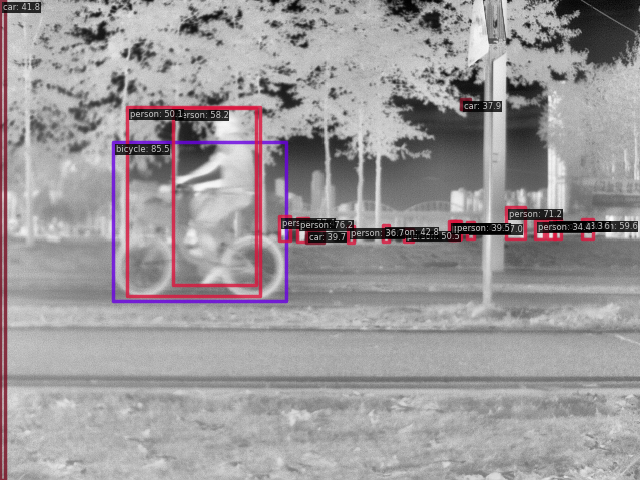

In [48]:
file = './mmyolo/data/all_dataset/test/test_open_115.png'

result = inference_detector(model, file)

img = mmcv.imread(file)
img = mmcv.imconvert(img, "bgr", "rgb")

filename = os.path.basename(file)
out_file = os.path.join(out_dir, filename)

# progress_bar.update()

# Get candidate predict info with score threshold
pred_instances = result.pred_instances[
    result.pred_instances.scores > score_thr
]


visualizer.add_datasample(
    filename,
    img,
    data_sample=result,
    draw_gt=False,
    show=False,
    wait_time=0,
    out_file=out_file,
    pred_score_thr=score_thr,
)
Image.open("mmyolo/out_dir/"+file.split("/")[-1])

In [49]:

test_dir_prefix = "mmyolo/data/all_dataset/test/"
images = os.listdir(test_dir_prefix)
sorted_images = natsorted(images)


In [50]:
sub_results = []
sub_results_for_fusion=[]
# total_num = 0
for image_dir in sorted_images:
    result = inference_detector(model, os.path.join(test_dir_prefix,image_dir))
#     with Image.open(os.path.join(test_dir_prefix,image_dir)) as img:
#         image_width, image_height = img.size  # Get width and height of the image
    bboxes = result.get("pred_instances").get("bboxes").tolist()
    scores = result.get("pred_instances").get("scores").tolist()
    labels = result.get("pred_instances").get("labels").tolist()
    obj_num = len(bboxes)
    for idx in range(obj_num):
#         if labels[idx] > 8:
#             print(result['predictions'][0]["labels"][idx])
        min_x, min_y, max_x, max_y = bboxes[idx]
        
        normalized_min_x = min_x / norm_scale
        normalized_min_y = min_y / norm_scale
        normalized_max_x = max_x / norm_scale
        normalized_max_y = max_y / norm_scale
        
        ret = {
            "image_id" : str(image_dir.split(".")[0]),
            "category_id" : labels[idx],
            "bbox":[
                min_x,
                min_y,
                max_x-min_x,
                max_y-min_y
            ],
            "score":scores[idx],
        }
        ret_fusion={
            "image_id" : str(image_dir.split(".")[0]),
            "category_id" : labels[idx],
            "bbox":[
                normalized_min_x,
                normalized_min_y,
                normalized_max_x,
                normalized_max_y
            ],
            "score":scores[idx],
        }

        sub_results.append(ret)
        sub_results_for_fusion.append(ret_fusion)
#     break
#     total_num+=1
#     print(total_num)
with open("/home/eslim/workspace/comp/results/ppy_base_tta.txt", "w") as file:
    json.dump(sub_results, file, indent=4)


with open("/home/eslim/workspace/comp/results/ppy_base_tta_confusion.txt", "w") as file:
    json.dump(sub_results_for_fusion, file, indent=4)